<div class="alert alert-block alert-info">

**TODO:**
* check all texts
* separate names for different models
* try scaled/unscaled data for trees
* have it without outputs on Github
    
</div>

# Shallow regression for vector data

Reminder: We are within supervised learning (we have labels/targets that are real values) -> Regression


This script reads zip code data produced by **vectorDataPreparations** and creates different machine learning models for
predicting the average zip code income from population and spatial variables.

It assesses the model accuracy with a test dataset but also predicts the number to all zip codes and writes it to a geopackage
for closer inspection

## 0. Prepare environment


In [13]:
import time
import geopandas as gpd
import pandas as pd
from math import sqrt
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor,ExtraTreesRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

import seaborn as sns

## 1. Read the data
### 1.1 Input and output file paths 

In [14]:
paavo_data = "../data/paavo"

### Relative path to the zip code geopackage file that was prepared by vectorDataPreparations.py
input_geopackage_path = os.path.join(paavo_data,"zip_code_data_after_preparation.gpkg")

### Output file. You can change the name to identify different regression models
output_geopackage_path = os.path.join(paavo_data,"median_income_per_zipcode_shallow_model.gpkg")

### 1.2 Read the input data to a Geopandas dataframe

In [15]:
original_gdf = gpd.read_file(input_geopackage_path)
original_gdf.head()

,postinumer,nimi,hr_mtu,euref_x,euref_y,pinta_ala,he_vakiy,he_naiset,he_miehet,he_kika,...,Pirkanmaa,Pohjanmaa,Pohjois-Karjala,Pohjois-Pohjanmaa,Pohjois-Savo,Päijät-Häme,Satakunta,Uusimaa,Varsinais-Suomi,geometry
0,00100,Helsinki Keskusta - Etu-Töölö,27577.0,0.467824,0.029171,0.000303,0.679496,0.664961,0.644436,0.288462,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((385653.893 6671591.048, 385573..."
1,00120,Punavuori,27523.0,0.468701,0.028337,0.000029,0.263362,0.258205,0.249572,0.269231,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((385316.092 6671076.984, 385279..."
2,00130,Kaartinkaupunki,30479.0,0.469833,0.028373,0.000031,0.055110,0.053156,0.053591,0.288462,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((386212.111 6671061.262, 386176..."
3,00140,Kaivopuisto - Ullanlinna,29439.0,0.470071,0.027735,0.000102,0.291434,0.295189,0.265798,0.288462,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((386577.050 6670280.544, 386552..."
4,00150,Eira - Hernesaari,26546.0,0.468366,0.027381,0.000163,0.345510,0.344729,0.320729,0.269231,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((384846.102 6669565.816, 384823..."


# 2. Train the model 

Here we try training different models. We encourage you to dive into the documentation of different models a bit and try different parameters. 

Which one is the best model? Can you figure out how to improve it even more?

### 2.1 Split the dataset to train and test datasets

In [23]:
### Split the gdf to x (the predictor attributes) and y (the attribute to be predicted)
y = original_gdf['hr_mtu'] # Average income

### Remove geometry and textual fields
x = original_gdf.drop(['geometry','postinumer','nimi','hr_mtu'],axis=1)

### Split the both datasets to train (80%) and test (20%) datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)


### 2.X Linear regression as comparison

Currently testing and evaluating; might not stay

In [30]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(x_train, y_train)
#print(regressor.intercept_)
#print(regressor.coef_)
feature_names = x.columns
model_coefficients = linear.coef_

coefficients_df = pd.DataFrame(data = model_coefficients, 
                              index = feature_names, 
                              columns = ['Coefficient value'])
print(coefficients_df)

print(linear.score(x_test, y_test))
print(linear.score(x_train, y_train))

                 Coefficient value
euref_x                 245.472829
euref_y               -3138.965227
pinta_ala              -519.491728
he_vakiy            -701947.425354
he_naiset           -704846.512958
...                            ...
Pohjois-Savo            -70.513793
Päijät-Häme            -237.434421
Satakunta              -177.736695
Uusimaa                 -67.035445
Varsinais-Suomi        -252.692260

[116 rows x 1 columns]
0.8501981542418442
0.8904321555840112


### 2.2 These are the functions used for training, estimating and predicting.

In [5]:
def trainModel(x_train, y_train, model):
    start_time = time.time()  
    print(model)
    model.fit(x_train,y_train)
    print('Model training took: ', round((time.time() - start_time), 2), ' seconds')
    return model

def estimateModel(x_test,y_test, model):
    ### Predict the unemployed number to the test dataset
    prediction = model.predict(x_test)
    
    ### Assess the accuracy of the model with root mean squared error, mean absolute error and coefficient of determination r2
    rmse = sqrt(mean_squared_error(y_test, prediction))
    mae = mean_absolute_error(y_test, prediction)
    r2 = r2_score(y_test, prediction)

    print(f"\nMODEL ACCURACY METRICS WITH TEST DATASET: \n" +
          f"\t Root mean squared error: {round(rmse)} \n" +
          f"\t Mean absolute error: {round(mae)} \n" +
          f"\t Coefficient of determination: {round(r2,4)} \n")

### 2.3 Run different models

### Gradient Boosting Regressor
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
* https://scikit-learn.org/stable/modules/ensemble.html#regression

In [6]:
gradboost = GradientBoostingRegressor(n_estimators=30, learning_rate=0.1,verbose=1)
model_name = "Gradient Boosting Regressor"
trainModel(x_train, y_train,grad_boost)
estimateModel(x_test,y_test, grad_boost)

GradientBoostingRegressor(n_estimators=30, verbose=1)
      Iter       Train Loss   Remaining Time 
         1     8668381.1560            1.01s
         2     7527263.4187            0.95s
         3     6578597.1849            0.90s
         4     5770589.0947            0.86s
         5     5087152.9130            0.83s
         6     4510100.2753            0.80s
         7     4031858.3436            0.76s
         8     3634256.0016            0.73s
         9     3296767.1062            0.69s
        10     3007253.3094            0.66s
        20     1627021.2128            0.32s
        30     1220796.5502            0.00s
Model training took:  0.96  seconds

MODEL ACCURACY METRICS WITH TEST DATASET: 
	 Root mean squared error: 1231 
	 Mean absolute error: 910 
	 Coefficient of determination: 0.8383 



### Random Forest Regressor

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
* https://scikit-learn.org/stable/modules/ensemble.html#forest

In [7]:
random_forest = RandomForestRegressor(n_estimators=30,verbose=1)
model_name = "Random Forest Regressor"
trainModel(x_train, y_train,random_forest)
estimateModel(x_test,y_test, random_forest)

RandomForestRegressor(n_estimators=30, verbose=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model training took:  2.28  seconds

MODEL ACCURACY METRICS WITH TEST DATASET: 
	 Root mean squared error: 1181 
	 Mean absolute error: 861 
	 Coefficient of determination: 0.8511 



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


### Extra Trees Regressor

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

In [8]:
extra_trees = ExtraTreesRegressor(n_estimators=30,verbose=1)
model_name = "Extra Trees Regressor"
trainModel(x_train, y_train,extra_trees)
estimateModel(x_test,y_test, extra_trees)

ExtraTreesRegressor(n_estimators=30, verbose=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model training took:  1.02  seconds

MODEL ACCURACY METRICS WITH TEST DATASET: 
	 Root mean squared error: 1143 
	 Mean absolute error: 832 
	 Coefficient of determination: 0.8605 



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


### Bagging Regressor

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
* https://scikit-learn.org/stable/modules/ensemble.html#bagging

In [9]:
bagging = BaggingRegressor(n_estimators=30,verbose=1)
model_name = "Bagging Regressor"
trainModel(x_train, y_train,bagging)
estimateModel(x_test,y_test, bagging)

BaggingRegressor(n_estimators=30, verbose=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model training took:  2.29  seconds

MODEL ACCURACY METRICS WITH TEST DATASET: 
	 Root mean squared error: 1204 
	 Mean absolute error: 872 
	 Coefficient of determination: 0.8453 



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


### AdaBoost Regressor

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
* https://scikit-learn.org/stable/modules/ensemble.html#adaboost

In [10]:
ada_boost = AdaBoostRegressor(n_estimators=30)
model_name = "AdaBoost Regressor"
trainModel(x_train, y_train,ada_boost)
estimateModel(x_test,y_test, ada_boost)

AdaBoostRegressor(n_estimators=30)
Model training took:  0.72  seconds

MODEL ACCURACY METRICS WITH TEST DATASET: 
	 Root mean squared error: 1394 
	 Mean absolute error: 1099 
	 Coefficient of determination: 0.7927 



# 3. Predict average income to all zip codes
Here we predict the average income to the whole dataset. Prediction is done with the model you have stored in the model variable - the one you ran last

In [11]:
### Print chosen model 

model = ada_boost
print(model)

### Drop the not-used columns from original_gdf as done before model training.
x = original_gdf.drop(['geometry','postinumer','nimi','hr_mtu'],axis=1)

### Predict the median income with already trained model
prediction = model.predict(x)

### Join the predictions to the original geodataframe and pick only interesting columns for results
original_gdf['predicted_hr_mtu'] = prediction.round(0)
original_gdf['difference'] = original_gdf['predicted_hr_mtu'] - original_gdf['hr_mtu']
resulting_gdf = original_gdf[['postinumer','nimi','hr_mtu','predicted_hr_mtu','difference','geometry']]

AdaBoostRegressor(n_estimators=30)


<AxesSubplot: title={'center': 'Predicted average income by zip code AdaBoost Regressor'}>

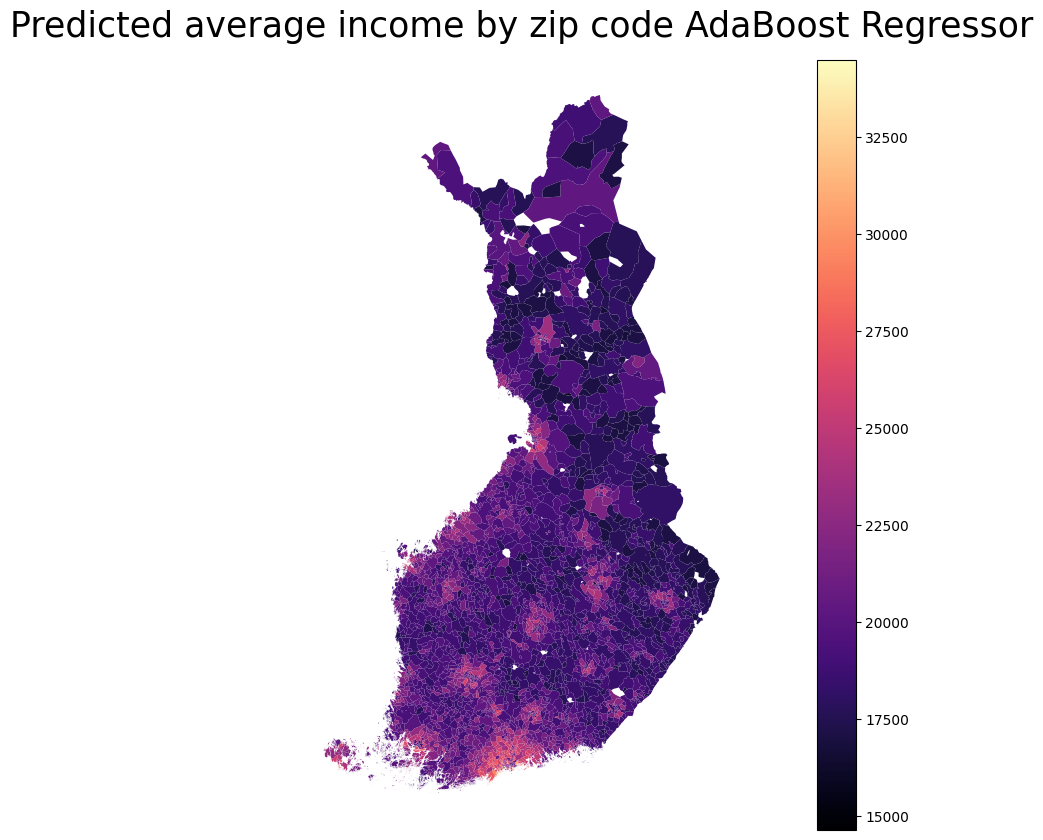

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Predicted average income by zip code " + model_name, fontsize=25)
ax.set_axis_off()
resulting_gdf.plot(column='predicted_hr_mtu', ax=ax, legend=True, cmap="magma")

# 4. EXERCISE: Calculate the difference between real and predicted incomes

Calculate the difference of real and predicted income amounts by zip code level and plot a map of it

* **original_gdf** is the original dataframe
* **resulting_gdf** is the predicted one